In [1]:
library(tidyverse)
library(ggpubr)
library(reshape2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
AML_clean = read_csv('../data/large_cleaned.csv') 

Parsed with column specification:
cols(
  .default = col_double(),
  country_name = col_character(),
  category_name = col_character()
)

See spec(...) for full column specifications.



In [3]:
labels = read_csv('../data/jeopardy.csv')
AML_clean = AML_clean %>%
   merge(labels, by = 'cif', all.x = T)

Parsed with column specification:
cols(
  cif = col_double(),
  suspicious = col_double()
)



In [4]:

columns_to_remove = c('turnover','atm_withdrawal','atm_deposit',
                      'transaction_count', 'nationality','distinct_counterparties','inactive_days_average',
                      'atm_deposit_norm','atm_withdrawal_norm','category','is_pep','nationality','new_category')
AML_loged = AML_clean %>%
  column_to_rownames(var = 'cif') %>%
  select(-one_of(columns_to_remove))%>%
    mutate(suspicious = as.factor(suspicious),
          no_atm_deposit= as.factor(no_atm_deposit),
           no_atm_withdrawal= as.factor(no_atm_withdrawal))

In [5]:
names(AML_loged)

[1] "io_ratio"                    "age"                        
 [3] "inactive_days_max"           "n_of_accounts"              
 [5] "channel_risk"                "aml_risk_score"             
 [7] "aml_risk_ranking"            "country_name"               
 [9] "cpi_risk_score"              "cpi_risk_ranking"           
[11] "transaction_avg"             "turnover_log"               
[13] "atm_withdrawal_log"          "atm_deposit_log"            
[15] "transaction_count_log"       "distinct_counterparties_log"
[17] "atm_withdrawal_norm_log"     "atm_deposit_norm_log"       
[19] "inactive_days_average_log"   "category_name"              
[21] "no_atm_deposit"              "no_atm_withdrawal"          
[23] "suspicious"

In [6]:
categorical_columns = c('category_name','suspicious','no_atm_deposit','no_atm_withdrawal')
AML_long = AML_loged %>%
    rownames_to_column(var = "cif") %>%
    melt(id.vars = c('cif',categorical_columns)) %>%
    mutate(suspicious = as.factor(suspicious),
          no_atm_deposit= as.factor(no_atm_deposit),
           no_atm_withdrawal= as.factor(no_atm_withdrawal))

In [7]:
AML_long = AML_long %>%
mutate(value = as.numeric(value))
sapply(AML_long, class)

Warning message:
“в результате преобразования созданы NA”


cif     category_name        suspicious    no_atm_deposit 
      "character"       "character"          "factor"          "factor" 
no_atm_withdrawal          variable             value 
         "factor"          "factor"         "numeric"

In [8]:
head(AML_long %>% filter(variable == 'io_ratio') %>% select(value, suspicious, variable))

value,suspicious,variable
<dbl>,<fct>,<fct>
0.3040000,0,io_ratio
0.2500000,0,io_ratio
0.0000000,0,io_ratio
0.2391304,0,io_ratio
0.3650794,0,io_ratio
0.3333333,0,io_ratio


In [9]:
predictive_columns_sel_2 = c('io_ratio','turnover_log','channel_risk','age')
densplot_list_suspicious_best_2 = lapply(predictive_columns_sel_2, function(x){
    ggplot(AML_long %>% filter(variable == x) %>%
           mutate(suspicious = ifelse(suspicious == 1, 'suspicious','innocent')), 
           aes(x = value, color = suspicious, fill = suspicious)) +
geom_density(alpha = .3) +
ggtitle(x)+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
    scale_color_manual(values = c('#B35900','#0059B3'))+
    scale_fill_manual(values = c('#B35900','#0059B3'))
})

In [10]:
AML_long %>% filter(variable == 'io_ratio') %>% 
select(value, suspicious, variable) %>% 
group_by(suspicious) %>% summarize(n = n())

suspicious,n
<fct>,<int>
0,982094
1,17138


In [11]:
selected_columns = c('io_ratio','turnover_log','channel_risk','age')
densplot_list_suspicious = lapply(selected_columns, function(x){
    ggplot(AML_long %>% filter(variable == x), 
           aes(x = value, color = suspicious, fill = suspicious)) +
geom_density(alpha = .3) +
ggtitle(x)+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
    scale_color_manual(values = c('#B35900','#0059B3'))+
    scale_fill_manual(values = c('#B35900','#0059B3'))
})

Saving 7 x 7 in image



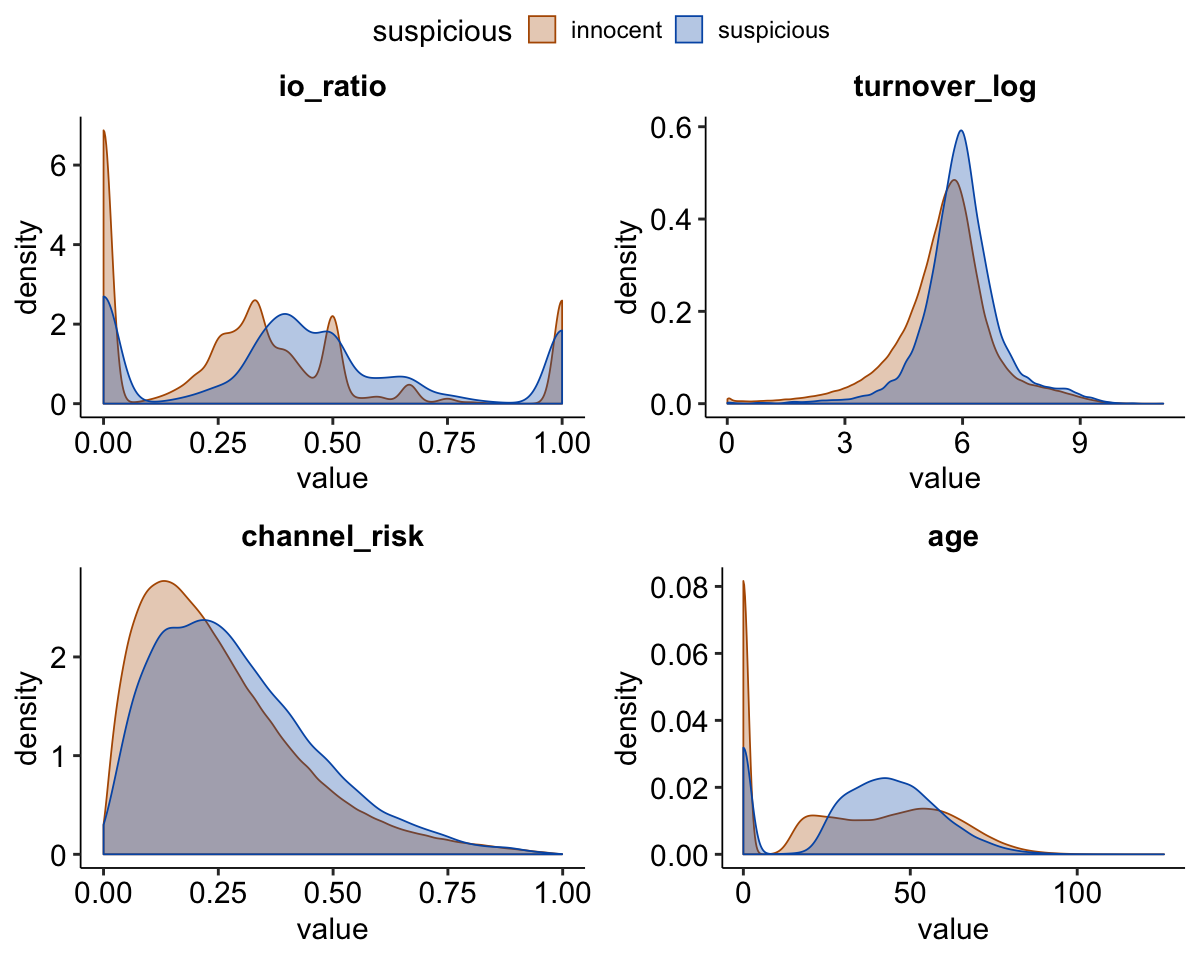

In [12]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggarrange(plotlist=densplot_list_suspicious_best_2, ncol = 2, nrow = 2, common.legend = T)
ggsave('feature_distribution.pdf')

In [13]:
predictive_pairs = list(c('turnover_log','inactive_days_average_log'),c('age','turnover_log'))
countour_plot_list = lapply(predictive_pairs, function(pair){
ggplot(AML_loged %>%
           mutate(suspicious = ifelse(suspicious == 1, 'suspicious','innocent'), 
       aes_string(x = pair[1], y = pair[2]))+
 stat_density_2d(geom = "polygon", aes(alpha = ..level../3, fill = suspicious))+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
    scale_color_manual(values = c('#B35900','#0059B3'))+
    scale_fill_manual(values = c('#B35900','#0059B3'))+
   scale_alpha_continuous(range = c(0.1, .3))+
    guides(alpha = FALSE)
})


ERROR: Error in parse(text = x, srcfile = src): <text>:13:1: неожиданный '}'
12:     guides(alpha = FALSE)
13: }
    ^


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 9)
ggarrange(plotlist=countour_plot_list, ncol = 2, common.legend = T)
ggsave('feature_interaction.pdf', height = 9, width = 8)

In [ ]:
predictive_columns = c('io_ratio','transaction_count_log','inactive_days_average_log',
                       'atm_withdrawal_log','turnover_log','channel_risk','cpi_risk_score')
densplot_list_suspicious = lapply(predictive_columns, function(x){
    ggplot(AML_long %>% filter(variable == x), 
           aes(x = value, color = suspicious, fill = suspicious)) +
geom_density(alpha = .3) +
ggtitle(x)+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))
})

In [ ]:
predictive_columns = c('io_ratio','transaction_count_log','inactive_days_average_log',
                       'atm_withdrawal_log','turnover_log','channel_risk','cpi_risk_score')
densplot_list_suspicious = lapply(predictive_columns, function(x){
    ggplot(AML_long %>% filter(variable == x) %>%
           mutate(suspicious = ifelse(suspicious == 1, 'suspicious','innocent')), 
           aes(x = value, color = suspicious, fill = suspicious)) +
geom_density(alpha = .3) +
ggtitle(x)+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
    scale_color_manual(values = c('#B35900','#0059B3'))+
    scale_fill_manual(values = c('#B35900','#0059B3'))
})

In [ ]:
options(repr.plot.width = 28, repr.plot.height = 39)
ggarrange(plotlist=densplot_list_suspicious, ncol = 3, nrow = 6)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 21)
ggarrange(plotlist=densplot_list_suspicious_best, ncol = 1)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)
ggarrange(plotlist=countour_plot_list, ncol = 2, common.legend = T)

In [ ]:
predictive_columns_sel_2 = c('io_ratio','turnover_log','channel_risk','age')
densplot_list_suspicious_best_2 = lapply(predictive_columns_sel_2, function(x){
    ggplot(AML_long %>% filter(variable == x) %>%
           mutate(suspicious = ifelse(suspicious == 1, 'suspicious','innocent')), 
           aes(x = value, color = suspicious, fill = suspicious)) +
geom_density(alpha = .3) +
ggtitle(x)+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
    scale_color_manual(values = c('#B35900','#0059B3'))+
    scale_fill_manual(values = c('#B35900','#0059B3'))
})

In [ ]:
predictive_pairs = list(c('io_ratio','transaction_count_log'),c('channel_risk','atm_deposit_norm_log'),
    c('turnover_log','inactive_days_average_log'),c('channel_risk','turnover_log'),
                       c('io_ratio','atm_withdrawal_log'),c('age','turnover_log'))
countour_plot_list = lapply(predictive_pairs, function(pair){
ggplot(AML_loged, 
       aes_string(x = pair[1], y = pair[2]))+
 geom_density_2d(aes(colour = as.factor(suspicious)))+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
    scale_color_manual(values = c('#B35900','#0059B3'))+
    scale_fill_manual(values = c('#B35900','#0059B3'))})

In [ ]:
options(repr.plot.width = 28, repr.plot.height = 10)
ggarrange(plotlist=countour_plot_list, ncol = 3)

In [ ]:
ggplot(AML_loged, 
       aes_string(x = 'io_ratio', y = 'transaction_count_log'))+
 geom_density_2d(aes(colour = suspicious))+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
scale_color_brewer(palette="Set1")
test

In [ ]:
predictive_pairs = list(c('io_ratio','transaction_count_log'),c('channel_risk','atm_deposit_norm_log'),
    c('turnover_log','inactive_days_average_log'),c('channel_risk','turnover_log'),
                       c('io_ratio','atm_withdrawal_log'),c('age','turnover_log'))
length(predictive_pairs)

In [ ]:
options(repr.plot.width = 28, repr.plot.height = 10)
ggarrange(plotlist=countour_plot_list, ncol = 3)

In [ ]:
ggsave('feature_interaction_final.pdf', height = 10, width = 20)

In [ ]:
predictive_pairs = list(c('io_ratio','transaction_count_log'),c('channel_risk','atm_deposit_norm_log'),
    c('turnover_log','inactive_days_average_log'),c('channel_risk','turnover_log'),
                       c('io_ratio','atm_withdrawal_log'),c('age','turnover_log'))
countour_plot_list = lapply(predictive_pairs, function(pair){
ggplot(AML_loged, 
       aes_string(x = pair[1], y = pair[2]))+
 stat_density_2d(geom = "polygon", aes(alpha = ..level.., fill = suspicious))+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
    scale_color_manual(values = c('#B35900','#0059B3'))+
    scale_fill_manual(values = c('#B35900','#0059B3'))})

In [ ]:
options(repr.plot.width = 28, repr.plot.height = 10)
ggarrange(plotlist=countour_plot_list, ncol = 3)

In [ ]:
predictive_pairs = list(c('io_ratio','transaction_count_log'),c('channel_risk','atm_deposit_norm_log'),
    c('turnover_log','inactive_days_average_log'),c('channel_risk','turnover_log'),
                       c('io_ratio','atm_withdrawal_log'),c('age','turnover_log'))
countour_plot_list = lapply(predictive_pairs, function(pair){
ggplot(AML_loged, 
       aes_string(x = pair[1], y = pair[2]))+
 stat_density_2d(geom = "polygon", aes(alpha = ..level.., fill = suspicious))+ 
theme_pubr(base_size = 18)+
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = 'bold'))+
    scale_color_manual(values = c('#B35900','#0059B3'))+
    scale_fill_manual(values = c('#B35900','#0059B3'))+
   scale_alpha_continuous(range = c(0.1, .3))})